<a href="https://colab.research.google.com/github/lexbetaOS/NLP-Models/blob/master/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LIBARIES' IMPORT**

In [0]:
cd /content/gdrive/My\ Drive/Colab\ Notebooks/lda2vec/

[Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/lda2vec/'
/content


In [0]:
pwd

'/content'

In [0]:
cat 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import Counter
#from sklearn.datasets import fetch_20newsgroups
import re
import string
from pprint import pprint
                                                           
import matplotlib.pyplot as plt

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SpanishStemmer

!pip install stop_words
!python -m spacy download es
!python -m spacy download es_core_news_sm
from stop_words import get_stop_words

# spacy for lemmatization
import spacy


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words
     |████████████████████████████████| 36.7MB 1.2MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-7c35eksz/wheels/9e/28/c4/df4980946eb229379ed26d349566e427fa029dbf03546ccb94
Successfully built es-core-news-sm

    Linking successful
    /usr/local/lib/python3.6/dist-packages/es_core_news_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/es

    You can now load the model via spacy.load('es')


    Linking successful
    /usr/local/lib/python3.6/dist-packages/es_core_news_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/es_core_news_sm

    You can now load the model via spacy.load('es_core_news_sm')



In [0]:
np.__version__

'1.16.3'

In [0]:
#utils
from md_utils import graph_error_models,category_to_target,corpus_to_input

# ***LOAD AND EXPLORED DATA***

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
df1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/lda2vec/out_AVP.csv')
print("Total de datos",len(df1))
df1.head(4)

Total de datos 5936


,Unnamed: 0,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Asunto,Clasificacion
0,0,0,1.0,0.7493,"consultar, bnf, solicitud, evaluacion, retenci...","['nuevo', 'webpyme']",RE: ***Nueva WEBPYME***,Consulta
1,1,1,0.0,0.8473,"cliente, eirl, diverso, idc, rebajar, peru, ta...","['tupaq', 'tour', 'peru', 'sac']",TUPAQ TOURS PERU SAC| RUC 20601204496,Consulta
2,2,2,1.0,0.7493,"consultar, bnf, solicitud, evaluacion, retenci...","['nuevo', 'webpyme']",RE: ***Nueva WEBPYME***,Consulta
3,3,3,3.0,0.4487,"plan, cambiar, dni, cliente, respuesta_automat...","['macro', 'retención', 'desactualizada', 'pers...",RE: Macro Retenciones Desactualizada// URG (pe...,Consulta


In [0]:
t1


print("Total de ",t1)
print(sum(df1['Clasificacion']=='Cambio de plan'))
print(sum(df1['Clasificacion']=='Creditos'))
print(sum(df1['Clasificacion']=='Excepcion'))

Total de datos 5936
Total de  1132
732
160
3912


In [0]:
da = df1.Clasificacion.values.tolist()
t1=sum([(d=='Consulta') for d in da])
t2=sum([(d=='Cambio de plan') for d in da])
t3=sum([(d=='Creditos') for d in da])
t4=sum([(d=='Excepcion') for d in da])
temp=[('Consulta',t1),('Cambio de plan',t2),('Creditos',t3),('Excepcion',t4)]

In [0]:
da=='Consulta'

False

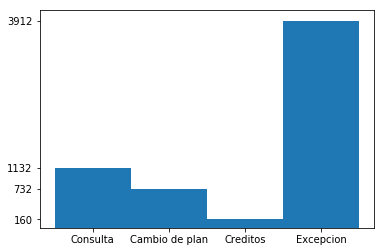

In [0]:
labels, ys = zip(*temp)
xs = np.arange(len(labels)) 
width = 1

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks(ys)
plt.show()
#plt.savefig('netscore.png')

# ***DATA CLEANING***

In [0]:
data1 = df1.Asunto.values.tolist()

data1 = [re.sub('\S*@\S*\s?', '', sent) for sent in data1]
data1 = [re.sub(r"http\S+", "", sent) for sent in data1]
data1 = [re.sub(r"(<[^>]*>)", " ", sent) for sent in data1]
#data1 = [re.sub("[^a-zA-Z]+", " ", sent) for sent in data1]
data1 = [re.sub(r"({[^}]*})", " ", sent) for sent in data1]
data1 = [re.sub('\s+', ' ', sent) for sent in data1]
data1 = [re.sub("\'", "", sent) for sent in data1]
data1 = [re.sub("\*", "", sent) for sent in data1]
data1 = [re.sub("\/", "", sent) for sent in data1]
data1 = [re.sub("\(", "", sent) for sent in data1]
data1 = [re.sub("\)", "", sent) for sent in data1]
data1 = [re.sub("\!", "", sent) for sent in data1]
data1 = [re.sub("\-", "", sent) for sent in data1]
data1 = [re.sub(r"(\[.*?\])", " ", sent) for sent in data1]
data1 = [re.sub(r"(RE:[^\w])", "", sent) for sent in data1]
data1 = [re.sub(r"(RV:[^\w])", "", sent) for sent in data1]
data1 = [re.sub(r"([\d\.])", "", sent) for sent in data1]
data1 = [re.sub("\:", "", sent) for sent in data1]

# ***CREATING TOKENS, N-GRAMS AND DICTIONARY***

In [0]:
stopwords_es = set(stopwords.words('spanish'))
stopwords_es_sw = set(get_stop_words('spanish'))

stopSpanish = set(stopwords_es.union(stopwords_es_sw))

stopSpanish = list(stopSpanish)

print(type(stopSpanish),len(stopSpanish))

<class 'list'> 317


In [0]:
#Tokenizacion
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True Elimina puntuaciones

data_words = list(sent_to_words(data1))

print(data_words[:2])

[['nueva', 'webpyme'], ['tupaq', 'tours', 'peru', 'sac', 'ruc']]


In [0]:
%%time
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['tupaq', 'tours', 'peru', 'sac', 'ruc']
CPU times: user 593 ms, sys: 5.53 ms, total: 598 ms
Wall time: 605 ms


In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopSpanish] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [0]:
%%time
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
#data_words_trigrams = make_trigrams(data_words_bigrams)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['nuevo', 'webpyme']]
CPU times: user 34.2 s, sys: 15.7 s, total: 49.8 s
Wall time: 26 s


In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [0]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('nuevo', 1), ('webpyme', 1)],
 [('peru', 1), ('sac', 1), ('tour', 1), ('tupaq', 1)],
 [('nuevo', 1), ('webpyme', 1)],
 [('desactualizada', 1), ('macro', 1), ('persistir', 1), ('retención', 1)],
 [('macro', 1), ('retención', 1), ('error', 1), ('tsn', 1)]]

# ***TF-IDF***

In [0]:
from gensim import corpora, models

tfidf = models.TfidfModel(corpus)

In [0]:
corpus = tfidf[corpus]

In [0]:
for doc in corpus:
    pprint(doc)
    break

[(0, 0.5668830586680931), (1, 0.8237982749405994)]


In [0]:
id2word.doc2idx(['error', 'macro', 'tsn', 'retención'])

[10, 7, 11, 9]

In [0]:
corpus[4]

[(7, 0.46042926557402186),
 (9, 0.46128333236895336),
 (10, 0.5986637165081339),
 (11, 0.4656439983702456)]

In [0]:
len(texts)

5936

# ***PREPARING DATA INPUTS FOR MODELS***

In [0]:
X=corpus_to_input(corpus,id2word)

In [0]:
X

array([[0.56688306, 0.82379827, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.31796989, ..., 0.        , 0.        ,
        0.        ],
       [0.56688306, 0.82379827, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.92924471,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.72514508,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [0]:
Y = df1.Clasificacion.values.tolist()
Y1,Y2=category_to_target(Y)

# ***GETTING TRAIN AND TEST SET***

In [0]:
# x is your dataset
#x = np.random.rand(100, 5)
indices = np.random.permutation(X.shape[0])
training_idx, test_idx = indices[:4748], indices[4748:]
training, test = X[training_idx,:], X[test_idx,:]
training_y1, test_y1 = Y1[training_idx], Y1[test_idx]
training_y11, test_y11 = Y2[training_idx], Y2[test_idx]

# ***MODELS***

## ***NEURAL NETWORK***

In [0]:
# Parameters
total_words=len(id2word)
learning_rate = 0.01
training_epochs = 10
batch_size = 150
display_step = 1

# Network Parameters
n_hidden_1 = 100      # 1st layer number of features
n_hidden_2 = 100       # 2nd layer number of features
n_input = total_words # Words in vocab
n_classes = 4         # Categories: graphics, sci.space and baseball

input_tensor = tf.placeholder(tf.float32,[None, n_input],name="input")
output_tensor = tf.placeholder(tf.float32,[None, n_classes],name="output") 

def multilayer_perceptron(input_tensor, weights, biases):
    layer_1_multiplication = tf.matmul(input_tensor, weights['h1'])
    layer_1_addition = tf.add(layer_1_multiplication, biases['b1'])
    layer_1 = tf.nn.relu(layer_1_addition)
    
    # Hidden layer with RELU activation
    layer_2_multiplication = tf.matmul(layer_1, weights['h2'])
    layer_2_addition = tf.add(layer_2_multiplication, biases['b2'])
    layer_2 = tf.nn.relu(layer_2_addition)
    
    # Output layer 
    out_layer_multiplication = tf.matmul(layer_2, weights['out'])
    out_layer_addition = out_layer_multiplication + biases['out']
    
    return out_layer_addition

In [0]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
prediction = multilayer_perceptron(input_tensor, weights, biases)

# Define loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=output_tensor))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Initializing the variables
init = tf.global_variables_initializer()

# [NEW] Add ops to save and restore all the variables
saver = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(training)/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x = training[i*batch_size:i*batch_size+batch_size]
            batch_y = training_y11[i*batch_size:i*batch_size+batch_size]
            #batch_x,batch_y = get_batch(data1,data2,i,batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            c,_ = sess.run([loss,optimizer], feed_dict={input_tensor: batch_x,output_tensor:batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "loss=", \
                "{:.9f}".format(avg_cost))
    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(output_tensor, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    total_test_data = len(test)
    batch_x_test = test
    batch_y_test = test_y11
    #batch_x_test,batch_y_test = get_batch(data3,data4,0,total_test_data)
    print("Accuracy:", accuracy.eval({input_tensor: batch_x_test, output_tensor: batch_y_test}))
    
    # [NEW] Save the variables to disk
    save_path = saver.save(sess, "/content/gdrive/My Drive/Colab Notebooks/lda2vec/out3/model.ckpt")
    print("Model saved in path: %s" % save_path)

Epoch: 0001 loss= 14.494594693
Epoch: 0002 loss= 1.940452454
Epoch: 0003 loss= 0.670429077
Epoch: 0004 loss= 0.379005704
Epoch: 0005 loss= 0.250119595
Epoch: 0006 loss= 0.255800504
Epoch: 0007 loss= 0.229102412
Epoch: 0008 loss= 0.257529512
Epoch: 0009 loss= 0.229601459
Epoch: 0010 loss= 0.238927464
Optimization Finished!
Accuracy: 0.9318182
Model saved in path: /content/gdrive/My Drive/Colab Notebooks/lda2vec/out3/model.ckpt


In [0]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "/content/gdrive/My Drive/Colab Notebooks/lda2vec/out3/model.ckpt")
    print("Model restored.")
    
    classification = sess.run(tf.argmax(prediction, 1), feed_dict={input_tensor: test})
    print("Predicted categories:", classification)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/lda2vec/out3/model.ckpt
Model restored.
Predicted categories: [3 3 3 ... 3 3 3]


## ***SVM***

In [0]:
from sklearn import svm

clf_top=svm.SVC(kernel='linear',C=0.1,decision_function_shape='ovr')
clf_top.fit(training,training_y1)

y_predsvm = clf_top.predict(test)

train_acc=clf_top.score(training,training_y1)
test_acc=clf_top.score(test,test_y1)

print(train_acc*100)
print(test_acc*100)

91.38584667228307
89.64646464646465


In [0]:
from sklearn import svm

clf_top=svm.SVC(kernel='linear',C=0.1,decision_function_shape='ovr')
clf_top.fit(training,training_y1)

y_predsvm = clf_top.predict(test)

train_acc=clf_top.score(training,training_y1)
test_acc=clf_top.score(test,test_y1)

print(train_acc*100)
print(test_acc*100)

97.64111204717776
96.04377104377105


## ***NAIVE BAYES***

In [0]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(training, training_y1)

#Predict the response for test dataset
y_pred = gnb.predict(test)

In [0]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_y1, y_pred))

Accuracy: 0.5673400673400674


## ***ERROR GRAPHS***

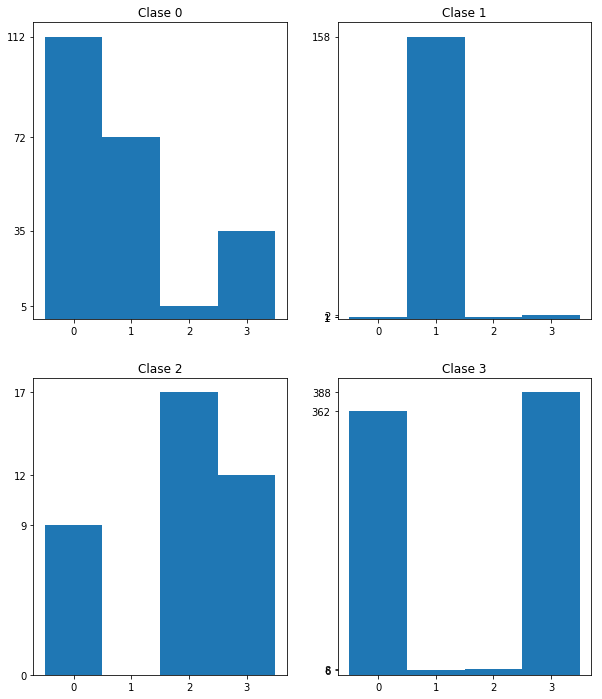

In [0]:
graph_error_models(2,2,test_y1,y_pred)

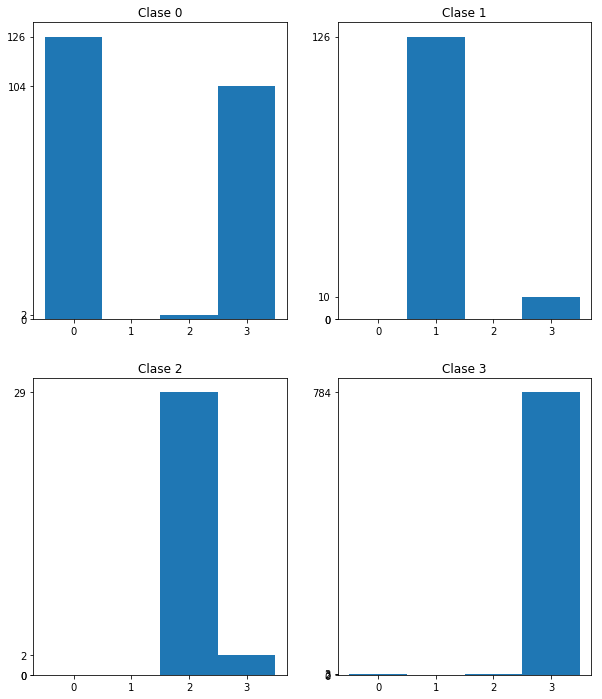

In [0]:
graph_error_models(2,2,test_y1,y_predsvm)

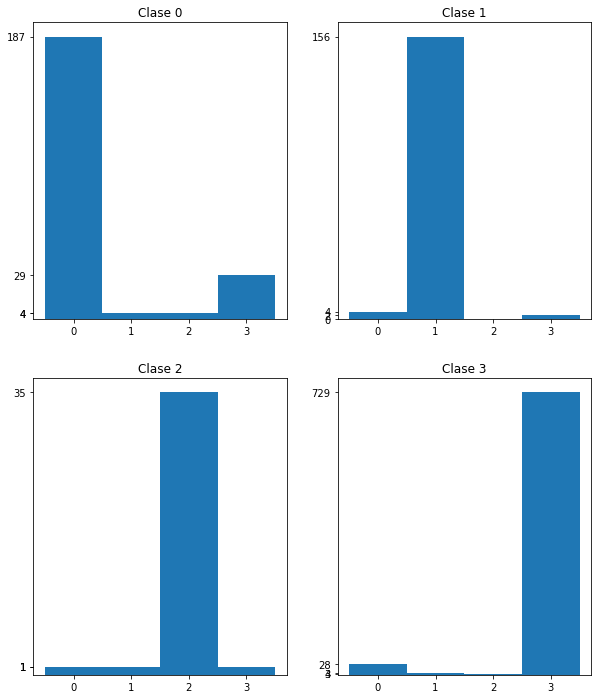

In [0]:
graph_error_models(2,2,test_y1,classification)